In [0]:
from pyspark.sql import functions as F

In [0]:
df = spark.read.table("msba_6331_group1.default.accidents_final")
df = df.withColumn("Start_Time", F.to_timestamp(df.Start_Time)) \
    .withColumn("End_Time", F.to_timestamp(df.End_Time)) \
    .withColumn("Severity", df.Severity.cast("double")) \
    .withColumn("accident_duration_mins", ((F.col("End_Time").cast("long") - F.col("Start_Time").cast("long"))/60))
# df.printSchema()
df.count()

50563

In [0]:
df_model = df.drop("ID", "Source", "Start_Time", "End_Time", "Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Street", "City", "County", "Zipcode", "Description", "Country", "Timezone", "Airport_Code", "Weather_Timestamp", "Wind_Direction", "Weather_Condition", "Distance_miles", "Precipitation_in")
df_model.limit(10).display()

Severity,State,Temperature_F,Wind_Chill_F,Humidity_percent,Pressure_in,Visibility_mi,Wind_Speed_mph,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,accident_duration_mins
0.0,CA,85.0,85.0,27.0,28.4,10.0,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,28.4
0.0,CA,92.0,92.0,26.0,29.79,10.0,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,103.95
0.0,OK,83.0,83.0,74.0,29.25,10.0,7.0,False,False,True,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night,74.6
1.0,IL,84.0,84.0,44.0,29.09,10.0,9.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,29.7
1.0,NY,75.0,75.0,78.0,29.57,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,104.5
1.0,CA,91.0,91.0,34.0,28.98,10.0,8.0,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day,284.8333333333333
0.0,NJ,82.0,82.0,74.0,29.86,10.0,5.0,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day,29.833333333333332
0.0,CA,83.0,83.0,47.0,29.75,10.0,12.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,29.933333333333334
0.0,NC,79.0,79.0,64.0,29.15,10.0,5.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,149.9
1.0,GA,74.0,74.0,97.0,28.88,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day,48.43333333333333


In [0]:
label = "Severity"

numerical_cols = ['Temperature_F', 'Wind_Chill_F', 'Humidity_percent', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'accident_duration_mins']

cat_cols = ['State'] 

boolean_cols = ['Amenity', 'Crossing','Give_Way','Junction', 'Railway', 'Station','Stop','Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']

In [0]:
from pyspark.ml.feature import OneHotEncoder, StandardScaler, SQLTransformer, StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml import Pipeline, PipelineModel

In [0]:

# df_model_si = si.fit(df_model_limit_10).transform(df_model_limit_10)
# df_model_si.display()

# df_model_ohe = ohe.fit(df_model_si).transform(df_model_si)
# df_model_ohe.display()

# df_model_num_va = va.transform(df_model_ohe)
# df_model_num_va.limit(10).display()

# df_model_scaled = sc.fit(df_model_num_va).transform(df_model_num_va)
# df_model_scaled.limit(10).display()

#df_model_va = va_features.transform(df_model_scaled)
# df_model_va.limit(10).display()

In [0]:
# cat_cols_ohe
si_input_cols = cat_cols + boolean_cols
si_output_cols = [ col+"_si" for col in si_input_cols]
ohe_input_cols = [ col+"_si" for col in cat_cols ]
ohe_output_cols = [ col+"_ohe" for col in cat_cols ]


si = StringIndexer(inputCols=si_input_cols, outputCols=si_output_cols, handleInvalid='keep')
ohe = OneHotEncoder(inputCols=ohe_input_cols, outputCols=ohe_output_cols, handleInvalid='keep')
va = VectorAssembler(inputCols = numerical_cols, outputCol="numerical_features")
sc = StandardScaler(inputCol="numerical_features", outputCol="numerical_scaled")

#combine all ohe + SI + sc
input_features = [col+"_ohe" for col in cat_cols] + [col+"_si" for col in boolean_cols] + [sc.
getOutputCol()]
va_features = VectorAssembler(inputCols=input_features, outputCol="features")


In [0]:
training, test = df_model.randomSplit([0.7, 0.3], 0)
 
training.cache()
test.cache()
 
print("There are {} training and {} test points.".format(training.count(), test.count()))

There are 35350 training and 15213 test points.


In [0]:
# StringIndexer: Convert the input column "label" (digits) to categorical values
# indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
# DecisionTreeClassifier: Learn to predict column "indexedLabel" using the "features" column
# dtc = DecisionTreeClassifier(labelCol="indexedLabel")
rf = RandomForestClassifier(featuresCol='features', labelCol="Severity")
# Chain indexer + dtc together into a single ML Pipeline
pipeline = Pipeline(stages=[si, ohe, va, sc, va_features, rf])

In [0]:
# Create an evaluator.  In this case, use "weightedPrecision".
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="Severity", metricName="areaUnderPR")
evaluator_roc = BinaryClassificationEvaluator(labelCol="Severity", metricName="areaUnderROC")

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Other imports and your model setup

# Set up the parameter grid
# grid = ParamGridBuilder() \
#     .addGrid(dtc.maxDepth, [4, 6]) \
#     .addGrid(dtc.maxBins, [4, 6]) \
#     .build()

grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.thresholds, [[0.2, 0.1], [0.3, 0.2], [0.5, 0.2]]) \
    .build()


# Set up cross-validation
# cv = CrossValidator(estimator=pipeline, evaluator=evaluator, estimatorParamMaps=grid, numFolds=3)
cv = CrossValidator(
    estimator=pipeline, 
    estimatorParamMaps=grid, 
    evaluator=evaluator_roc, 
    numFolds=5,
    collectSubModels=True  # Ensure this is set to True
)

# Run cross-validation
cvModel = cv.fit(training)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
pipeline_path = "dbfs:/FileStore/artifacts/pipeline_accidents/rf"
pipeline_model_path = "dbfs:/FileStore/artifacts/pipeline_model_accidents/rf"

pipeline.write().overwrite().save(pipeline_path)
cvModel.bestModel.write().overwrite().save(pipeline_model_path)

In [0]:
from pyspark.ml import Pipeline, PipelineModel
pipeline_for_inference = Pipeline.load(pipeline_path)
pipeline_model_for_inference = PipelineModel.load(pipeline_model_path)

In [0]:
cv_test_results = pipeline_model_for_inference.transform(test)
cv_test_results.limit(10).display()

Severity,State,Temperature_F,Wind_Chill_F,Humidity_percent,Pressure_in,Visibility_mi,Wind_Speed_mph,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,accident_duration_mins,State_si,Amenity_si,Crossing_si,Give_Way_si,Junction_si,Railway_si,Station_si,Stop_si,Traffic_Signal_si,Sunrise_Sunset_si,Civil_Twilight_si,Nautical_Twilight_si,Astronomical_Twilight_si,State_ohe,numerical_features,numerical_scaled,features,rawPrediction,probability,prediction
0.0,AL,26.0,16.0,44.0,29.58,10.0,12.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,59.71666666666667,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 48, indices -> List(18), values -> List(1.0))","Map(vectorType -> dense, length -> 7, values -> List(26.0, 16.0, 44.0, 29.579999923706055, 10.0, 12.0, 59.71666666666667))","Map(vectorType -> dense, length -> 7, values -> List(1.33717909079366, 0.7281454147755491, 1.9368537717406695, 25.97675222849733, 3.3518943006431408, 2.240165932825109, 0.019251490980561246))","Map(vectorType -> sparse, length -> 67, indices -> List(18, 60, 61, 62, 63, 64, 65, 66), values -> List(1.0, 1.33717909079366, 0.7281454147755491, 1.9368537717406695, 25.97675222849733, 3.3518943006431408, 2.240165932825109, 0.019251490980561246))","Map(vectorType -> dense, length -> 2, values -> List(19.553036141717673, 10.446963858282324))","Map(vectorType -> dense, length -> 2, values -> List(0.6517678713905891, 0.34823212860941083))",1.0
0.0,AL,37.9,32.7,93.0,30.25,10.0,6.9,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Day,29.6,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,"Map(vectorType -> sparse, length -> 48, indices -> List(18), values -> List(1.0))","Map(vectorType -> dense, length -> 7, values -> List(37.900001525878906, 32.70000076293945, 93.0, 30.25, 10.0, 6.900000095367432, 29.6))","Map(vectorType -> dense, length -> 7, values -> List(1.9491957531328108, 1.4881472261682074, 4.093804562997325, 26.56513715141323, 3.3518943006431408, 1.2880954291776767, 0.009542463851933233))","Map(vectorType -> sparse, length -> 67, indices -> List(18, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.9491957531328108, 1.4881472261682074, 4.093804562997325, 26.56513715141323, 3.3518943006431408, 1.2880954291776767, 0.009542463851933233))","Map(vectorType -> dense, length -> 2, values -> List(22.090100806885353, 7.90989919311464))","Map(vectorType -> dense, length -> 2, values -> List(0.7363366935628453, 0.26366330643715474))",0.0
0.0,AL,40.0,40.0,94.0,29.16,8.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,104.76666666666667,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 48, indices -> List(18), values -> List(1.0))","Map(vectorType -> dense, length -> 7, values -> List(40.0, 40.0, 94.0, 29.15999984741211, 8.0, 0.0, 104.76666666666667))","Map(vectorType -> dense, length -> 7, values -> List(2.0571986012210153, 1.8203635369388727, 4.1378239669005215, 25.607913893609638, 2.6815154405145125, 0.0, 0.033774734106560976))","Map(vectorType -> sparse, length -> 67, indices -> List(18, 60, 61, 62, 63, 64, 66), values -> List(1.0, 2.0571986012210153, 1.8203635369388727, 4.1378239669005215, 25.607913893609638, 2.6815154405145125, 0.033774734106560976))","Map(vectorType -> dense, length -> 2, values -> List(21.1036539822077, 8.896346017792299))","Map(vectorType -> dense, length -> 2, values -> List(0.7034551327402566, 0.29654486725974327))",1.0
0.0,AL,49.0,49.0,54.0,29.72,10.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,59.71666666666667,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Map(vectorType -> sparse, length -> 4

In [0]:
evaluator_roc.evaluate(cv_test_results)

0.7664917227297852

In [0]:
cv_test_results.groupBy("Severity", "Prediction").count().display()

Severity,Prediction,count
1.0,1.0,3330
0.0,1.0,4285
1.0,0.0,937
0.0,0.0,6661


Databricks visualization. Run in Databricks to view.

In [0]:
937 /cv_test_results.count() * 100

6.159205942286203

In [0]:
# len(cvModel.bestModel.stages[-1].featureImportances.toArray())
# stages[-1].getMaxDepth()

In [0]:
# cvModel.bestModel.stages[-1].featureImportances


In [0]:
fi = [ sum(cvModel.bestModel.stages[-1].featureImportances.toArray()[:48]) ]
# .append(cvModel.bestModel.stages[-1].featureImportances.values[48:])
fi 

[0.27832207499473044]

In [0]:
fi.extend(cvModel.bestModel.stages[-1].featureImportances.toArray()[48:])

In [0]:
all_features = input_features[:-1] + va.getInputCols()
# all_features

In [0]:
for f, i in zip(all_features, fi):
    print(f"feature {f} importance := {round(i, 4)}")

feature State_ohe importance := 0.2783
feature Amenity_si importance := 0.0016
feature Crossing_si importance := 0.0718
feature Give_Way_si importance := 0.0023
feature Junction_si importance := 0.0193
feature Railway_si importance := 0.0018
feature Station_si importance := 0.0062
feature Stop_si importance := 0.02
feature Traffic_Signal_si importance := 0.1383
feature Sunrise_Sunset_si importance := 0.0093
feature Civil_Twilight_si importance := 0.0101
feature Nautical_Twilight_si importance := 0.0122
feature Astronomical_Twilight_si importance := 0.0085
feature Temperature_F importance := 0.0337
feature Wind_Chill_F importance := 0.0331
feature Humidity_percent importance := 0.0428
feature Pressure_in importance := 0.0521
feature Visibility_mi importance := 0.0188
feature Wind_Speed_mph importance := 0.0374
feature accident_duration_mins importance := 0.2024


In [0]:
# bump, no_exit, roundabout, traffic_calming, turning_loop are not important

In [0]:
import matplotlib.pyplot as plt
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc
# Select the probability for the positive class
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType

# If the probability column is a vector (common in PySpark), extract the relevant probability
to_prob_udf = F.udf(lambda v: float(v[1]), FloatType())
cv_test_results_2 = cv_test_results.withColumn("probability", to_prob_udf("probability"))

# Collect the data to the driver
local_data = cv_test_results_2.select("Severity", "probability").toPandas()

fpr, tpr, thresholds = roc_curve(local_data['Severity'], local_data['probability'])
roc_auc = auc(fpr, tpr)

# fpr, tpr, thresholds, roc_auc

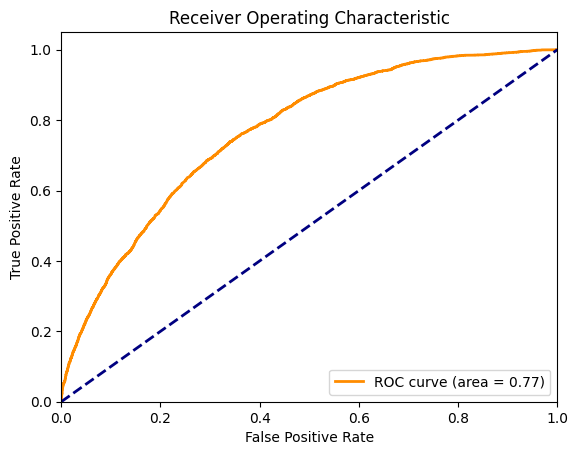

In [0]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [0]:
cvModel.bestModel.stages[-1].getThresholds() #getParam('thresholds')

[0.5, 0.2]